# Comb Drive

Fixed (stator) and moving (rotor) comb drive components for the MEMS electrostatic actuator.

In [1]:
import sys
sys.path.insert(0, "../../libraries")

import gdsfactory as gf
from mcw_custom_optical_mems_pdk import LAYER, PDK

PDK.activate()


def make_etch_hole(size=10.0, margin=0.5, layer=LAYER.POLY_MEMS):
    """Single square etch hole with margin offset from origin.

    Args:
        size:   Side length of the hole (um).
        margin: Offset from (0,0) so the hole is inset within a grid cell.
        layer:  GDS layer for the hole polygon.

    Returns:
        gf.Component with one square polygon.
    """
    c = gf.Component()
    c.add_polygon(
        [(margin, margin),
         (margin + size, margin),
         (margin + size, margin + size),
         (margin, margin + size)],
        layer=layer,
    )
    return c

In [2]:
def make_fixed_comb_drive(
    n_fingers: int = 40,
    finger_width: float = 0.5,
    finger_gap: float = 0.3,
    finger_length: float = 6.0,
    anchor_height: float = 15.0,
    psg_inset: float = 2.0,
    struct_layer=LAYER.POLY_MEMS,
    sac_layer=LAYER.OXIDE_PSG,
    anchor_poly_layer=LAYER.POLY_ANCHOR,
    anchor_si_layer=LAYER.SI_FULL,
):
    """Fixed (stator) comb drive: anchor pad with downward-hanging finger array.

    Finger geometry:
        pitch = 2 * finger_width + 2 * finger_gap
        anchor_width = n_fingers * pitch  (array spans full anchor)

    Args:
        n_fingers:         Number of comb fingers.
        finger_width:      Width of each finger (um).
        finger_gap:        Lateral gap between adjacent fingers (um).
        finger_length:     Length of each finger (um).
        anchor_height:     Height of the anchor pad (um).
        psg_inset:         Inset of PSG window from anchor edges (um).
        struct_layer:      Structural poly-Si layer.
        sac_layer:         Sacrificial PSG layer.
        anchor_poly_layer: Undoped poly anchor layer.
        anchor_si_layer:   SOI anchor layer.
    """
    pitch = 2 * finger_width + 2 * finger_gap
    anchor_width = n_fingers * pitch

    cd = gf.Component()

    # --- Anchor ---
    anchor = gf.Component()
    anchor_rect = [(0, 0), (anchor_width, 0),
                   (anchor_width, anchor_height), (0, anchor_height)]
    anchor.add_polygon(anchor_rect, layer=struct_layer)
    anchor.add_polygon(
        [(psg_inset, psg_inset),
         (anchor_width - psg_inset, psg_inset),
         (anchor_width - psg_inset, anchor_height - psg_inset),
         (psg_inset, anchor_height - psg_inset)],
        layer=sac_layer,
    )
    anchor.add_polygon(anchor_rect, layer=anchor_poly_layer)
    anchor.add_polygon(anchor_rect, layer=anchor_si_layer)

    # --- Fingers (hanging downward from y=0) ---
    finger = gf.Component()
    finger.add_polygon(
        [(0, 0), (0, -finger_length),
         (finger_width, -finger_length), (finger_width, 0)],
        layer=struct_layer,
    )

    cd.add_ref(anchor)
    cd.add_ref(finger, columns=n_fingers, rows=1,
               column_pitch=pitch, row_pitch=pitch)
    return cd

In [3]:
def make_moving_comb_drive(
    n_fingers: int = 40,
    finger_width: float = 0.5,
    finger_gap: float = 0.3,
    finger_length: float = 6.0,
    anchor_width: float = 69.5,
    anchor_height: float = 11.0,
    n_hole_cols: int = 7,
    hole_size: float = 10.0,
    hole_margin: float = 0.5,
    hole_pitch: float = 10.5,
    struct_layer=LAYER.POLY_MEMS,
):
    """Moving (rotor) comb drive: anchor slab with etch holes + downward finger array.

    The anchor is attached to the shuttle and freed during release, so it has
    no anchor pads — only structural POLY_MEMS with etch holes.

    Args:
        n_fingers:    Number of comb fingers.
        finger_width: Width of each finger (um).
        finger_gap:   Lateral gap between fingers (um).
        finger_length:Length of each finger (um).
        anchor_width: Width of the moving anchor slab (um).
        anchor_height:Height of the moving anchor slab (um).
        n_hole_cols:  Number of etch-hole columns in the anchor.
        hole_size:    Etch hole side length (um).
        hole_margin:  Etch hole inset from (0,0) (um).
        hole_pitch:   Etch hole pitch (um).
        struct_layer: Structural poly-Si layer.
    """
    pitch = 2 * finger_width + 2 * finger_gap

    # --- Anchor outline ---
    anchor_outline = gf.Component()
    anchor_outline.add_polygon(
        [(0, 0), (anchor_width, 0),
         (anchor_width, anchor_height), (0, anchor_height)],
        layer=struct_layer,
    )

    # --- Etch holes ---
    etch_hole = make_etch_hole(size=hole_size, margin=hole_margin, layer=struct_layer)
    holes = gf.Component()
    holes.add_ref(etch_hole, columns=n_hole_cols, rows=1,
                  column_pitch=hole_pitch, row_pitch=hole_pitch)

    cd_mov = gf.boolean(
        A=anchor_outline, B=holes, operation="not",
        layer1=struct_layer, layer2=struct_layer, layer=struct_layer,
    )

    # --- Fingers ---
    finger = gf.Component()
    finger.add_polygon(
        [(0, 0), (0, -finger_length),
         (finger_width, -finger_length), (finger_width, 0)],
        layer=struct_layer,
    )

    cd_mov.add_ref(finger, columns=n_fingers, rows=1,
                   column_pitch=pitch, row_pitch=pitch)
    return cd_mov

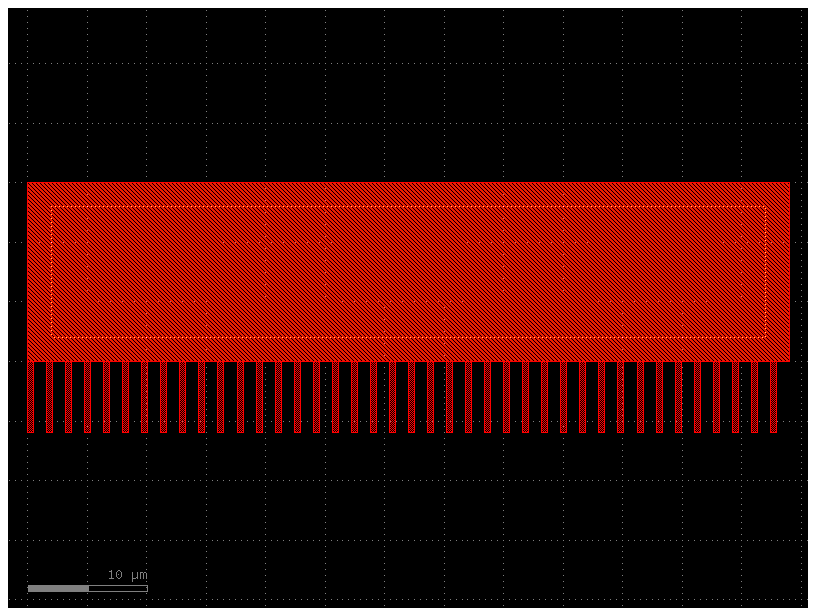

In [4]:
cd = make_fixed_comb_drive()
cd.plot()

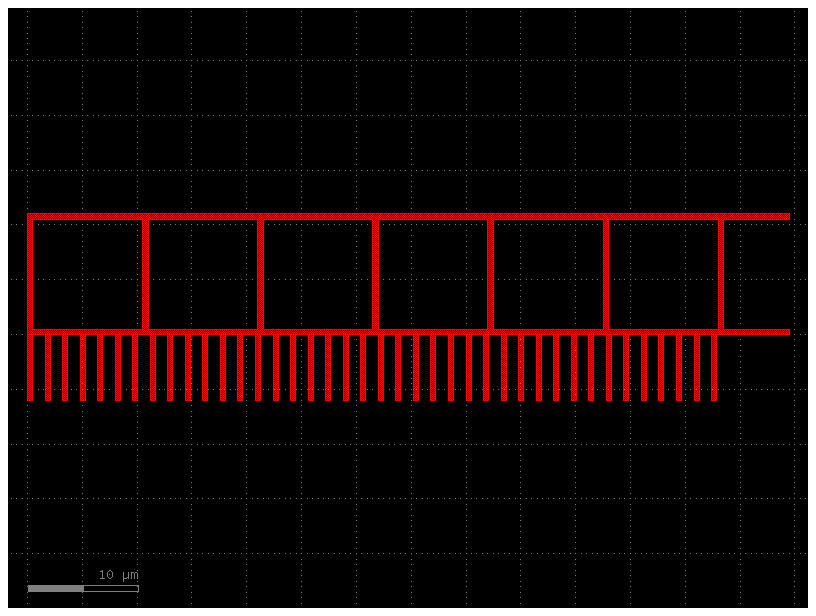

In [5]:
cd_mov = make_moving_comb_drive()
cd_mov.plot()